In [5]:
%matplotlib inline

In [6]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from sklearn.datasets import fetch_openml
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels \
    import RBF, WhiteKernel, RationalQuadratic, ExpSineSquared

print(__doc__)

#read the csv file into dataframe
dataset = pd.read_csv("GPR/LALearnOzoneGPR.csv")
dataset.head()




Automatically created module for IPython interactive environment


,DMax Ozone,Year,Month,Day,OZONE-WEIGHT,Flag,Site Name,Lat,Lng,Date
0,0.037,2016,1,1,17,0,Los Angeles-North Main Street,34.06659,-118.22688,1/1/2016
1,0.037,2016,1,1,17,0,Los Angeles-North Main Street,34.06659,-118.22688,1/1/2016
2,0.030,2016,1,7,13,0,Los Angeles-North Main Street,34.06659,-118.22688,1/7/2016
3,0.017,2016,1,13,17,0,Los Angeles-North Main Street,34.06659,-118.22688,1/13/2016
4,0.017,2016,1,13,17,0,Los Angeles-North Main Street,34.06659,-118.22688,1/13/2016


In [7]:
#target
y = dataset.iloc[:,0]

#dataset
X = dataset.iloc[:,1:6]
X.columns
#X.drop(['Site Name'],axis=1)


Index(['Year', 'Month', 'Day', 'OZONE-WEIGHT', 'Flag'], dtype='object')

C:\Users\eveba\.conda\envs\Machine_Learning\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
<ipython-input-8-d25b49a3c98b>:77: RuntimeWarning: invalid value encountered in log10
  level = np.around(np.logspace(np.log10(vmin), np.log10(vmax), 50), decimals=1)
<ipython-input-8-d25b49a3c98b>:78: UserWarning: Log scale: values of z <= 0 have been masked
  plt.contour(Theta0, Theta1, -LML,


ValueError: minvalue must be positive

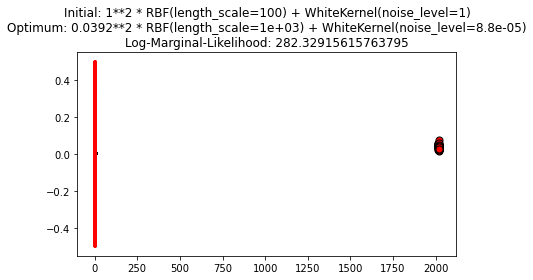

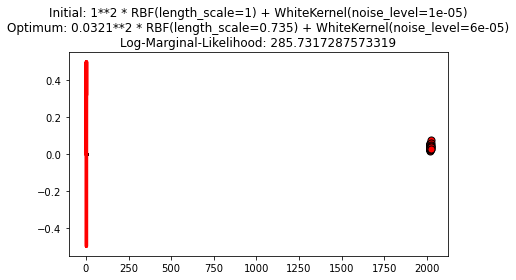

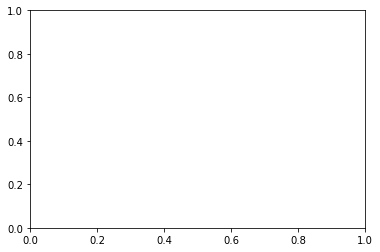

In [8]:
def Ozone_prep():

    months = []
    ppmv_sums = []
    counts = []
    
    m = X['Month']
    year = X['Year']
    month_float = year + (m - 1) / 12
    ppmvs = dataset.iloc[:,0]

    for month, ppmv in zip(month_float, ppmvs):
            if not months or month != months[-1]:
                months.append(month)
                ppmv_sums.append(ppmv)
                counts.append(1)
            else:
                # aggregate monthly sum to produce average
                ppmv_sums[-1] += ppmv
                counts[-1] += 1
            
    months = np.asarray(months).reshape(-1, 1)
    avg_ppmvs = np.asarray(ppmv_sums) / counts
    return months, avg_ppmvs
 
newX, newy = Ozone_prep()   

# First run
plt.figure()
kernel = 1.0 * RBF(length_scale=100.0, length_scale_bounds=(1e-2, 1e3)) \
    + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))
gp = GaussianProcessRegressor(kernel=kernel,
                              alpha=0.0).fit(newX, newy)
X_ = np.linspace(0, 5, 100)
y_mean, y_cov = gp.predict(X_[:, np.newaxis], return_cov=True)
plt.plot(X_, y_mean, 'k', lw=3, zorder=9)
plt.fill_between(X_, y_mean - np.sqrt(np.diag(y_cov)),
                 y_mean + np.sqrt(np.diag(y_cov)),
                 alpha=0.5, color='k')
plt.plot(X_, 0.5*np.sin(3*X_), 'r', lw=3, zorder=9)
plt.scatter(newX[:, 0], newy, c='r', s=50, zorder=10, edgecolors=(0, 0, 0))
plt.title("Initial: %s\nOptimum: %s\nLog-Marginal-Likelihood: %s"
          % (kernel, gp.kernel_,
             gp.log_marginal_likelihood(gp.kernel_.theta)))
plt.tight_layout()

# Second run
plt.figure()
kernel = 1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3)) \
    + WhiteKernel(noise_level=1e-5, noise_level_bounds=(1e-10, 1e+1))
gp = GaussianProcessRegressor(kernel=kernel,
                              alpha=0.0).fit(newX, newy)
X_ = np.linspace(0, 5, 100)
y_mean, y_cov = gp.predict(X_[:, np.newaxis], return_cov=True)
plt.plot(X_, y_mean, 'k', lw=3, zorder=9)
plt.fill_between(X_, y_mean - np.sqrt(np.diag(y_cov)),
                 y_mean + np.sqrt(np.diag(y_cov)),
                 alpha=0.5, color='k')
plt.plot(X_, 0.5*np.sin(3*X_), 'r', lw=3, zorder=9)
plt.scatter(newX[:, 0], newy, c='r', s=50, zorder=10, edgecolors=(0, 0, 0))
plt.title("Initial: %s\nOptimum: %s\nLog-Marginal-Likelihood: %s"
          % (kernel, gp.kernel_,
             gp.log_marginal_likelihood(gp.kernel_.theta)))
plt.tight_layout()

# Plot LML landscape
plt.figure()
theta0 = np.logspace(-2, 3, 49)
theta1 = np.logspace(-2, 0, 50)
Theta0, Theta1 = np.meshgrid(theta0, theta1)
LML = [[gp.log_marginal_likelihood(np.log([0.36, Theta0[i, j], Theta1[i, j]]))
        for i in range(Theta0.shape[0])] for j in range(Theta0.shape[1])]
LML = np.array(LML).T

vmin, vmax = (-LML).min(), (-LML).max()
vmax = 50
level = np.around(np.logspace(np.log10(vmin), np.log10(vmax), 50), decimals=1)
plt.contour(Theta0, Theta1, -LML,
            levels=level, norm=LogNorm(vmin=vmin, vmax=vmax))
plt.colorbar()
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Length-scale")
plt.ylabel("Noise-level")
plt.title("Log-marginal-likelihood")
plt.tight_layout()

plt.show()

